<a href="https://colab.research.google.com/github/PerifanosPrometheus/GiorgioDiSalvo/blob/master/Table1_spherical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spherical clustering of DCSBM

This Notebook attempts to compare the ARI obtained by fitting Gaussian mixture models(GMM) to the latent positions obtained from Adjacency spectral embedding of DCSBM graphs versus fitting GMM to the same latent positions but expressed in spherical coordinates as described by [Passino et al.](https://arxiv.org/pdf/2011.04558.pdf). 


Synthetic data will be simulated by sampling undirected graphs from degree-corrected stochastic blockmodels(DCSBM) with a fixed number of communities $K=3$. Each graph is simulated by randomly selecting $B \sim Uniform(0, 1)^{K×K}$ and sampling the degree correction parameters
$\rho_i \sim Beta(2, 1)$.

### Import

Let's first import relevant packages

In [1]:
#! /usr/bin/env python3
import numpy as np
import argparse
from collections import Counter
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
from sklearn.preprocessing import scale
from scipy.stats import chi2, norm
from sklearn.metrics import adjusted_rand_score as ari
!pip install graspologic
import graspologic
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.cluster import AutoGMMCluster
from sklearn.preprocessing import normalize
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



     |████████████████████████████████| 5.1MB 5.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 942kB 35.2MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 440kB 35.8MB/s 
     |████████████████████████████████| 24.2MB 1.9MB/s 
  Created wheel for graspologic: filename=graspologic-0.1.0-cp37-none-any.whl size=5147502 sha256=f90a26cd47e6057665c7860fcd9e66c3b4b7fc594b6cc736d60be73bd9d922d1
  Stored in directory: /root/.cache/pip/wheels/8b/93/4f/7e45490d6f3cb0d3c7e6d709f469a55200646ee3da01ba4150
Successfully built graspologic
  Created wheel for hyppo: filename=hyppo-0.1.3-cp37-none-any.whl size=64218 sha256=3efafe80034983d76ce6b7ea8fba24a5b95a4296d15573065c3d9dcb99cb4079
  Stored in directory: /root/.cache/pip/wheels/c0/ad/6b/e2bf22a0f13f40c1bc10ba65e8b5cf1b3dc4cf9aeb803316

## Function converting cartesian to spherical coordinates

Let's no define a function to perform transformation of coordinates.

In [2]:
#Code provided by Passino et al.
## Takes a vector and returns its spherical coordinates
def cart_to_sphere(x):
    ## theta_1
    q = np.arccos(x[1] / np.linalg.norm(x[:2]))
    sphere_coord = [q] if x[0] >= 0 else [2*np.pi - q]
    ## Loop for theta_2, ..., theta_m-1
    for j in range(2,len(x)):
      sphere_coord += [2 * np.arccos(x[j] / np.linalg.norm(x[:(j+1)]))]
    ## Return the result in a numpy array
    return np.array(sphere_coord)

## Takes a matrix and returns the spherical coordinates obtained along the given axis
def theta_transform(X,axis=1):
    ## Apply the function theta_transform along the axis
    return np.apply_along_axis(func1d=cart_to_sphere, axis=axis, arr=X)

# Function to plot histograms of latent positions

In [3]:
def simple_scatter(X, ax, y=None, title = None):
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=y,
        s=15,
        linewidth=0.25,
        alpha=0.5,
        ax=ax,
        legend=False,
    )
    ax.set(xticks=[-0.6, 0.1], yticks=[-0.5, 0.5], xlabel=r"$\mathbf{X}_1$", ylabel=r"$\mathbf{X}_2$", xlim=(-1, 1), ylim=(-1, 1), title=r"$\hat\mathbf{X}$")
    ax.set_title(title)

# Visual intuition

Let's first develop a simple visual intuition.

Here we simulate a graph $G\sim DCSBM$ with the following parameters:

$n = 500\\
K=2\\
\rho_{i}\sim Beta(2,1)\\
B = \begin{bmatrix}0.1 & 0.05\\
0.05 & 0.15 \end{bmatrix}$

We then perform Adjacency Spectral Embedding and to obtain the latent positions $X$. We will also compute $\bar X$ as the normalized latent positions for $X$ and $\Theta$ as representation of $X$ in spherical coordinates on the unit sphere. 

Finally we plot the histograms for $X$,$\bar X$, and $\Theta$.

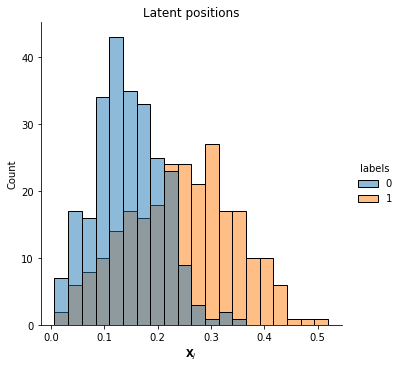

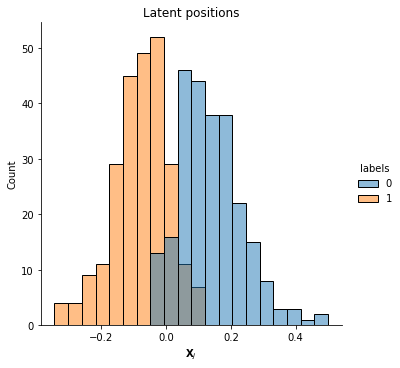

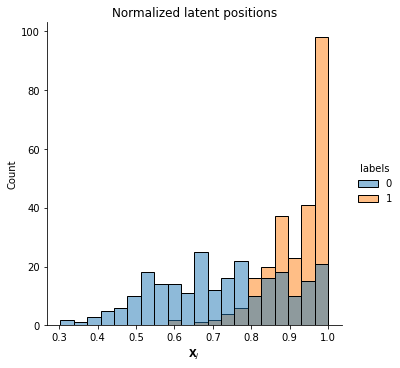

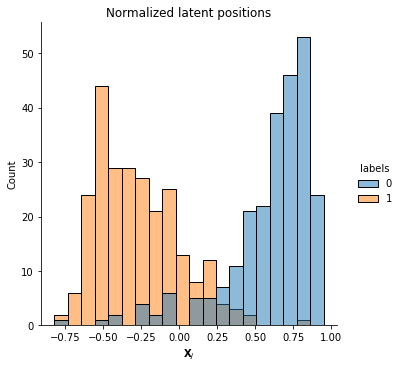

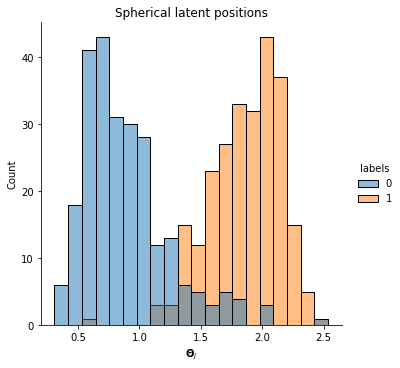

In [6]:
K = 2
n = 500

## Set seed to repeat the simulation
np.random.seed(14441)
q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
z = np.zeros(n,dtype=int)
for k in range(K):
    z[q[k]:] = k

B = np.vstack(([0.1,0.05],[0.05,0.15]))

rho = np.random.beta(a=2,b=1,size=n)
## Construct the adjacency matrix
A = np.zeros((n,n))
for i in range(n-1):
    for j in range(i+1,n):
        edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
        A[i,j] = edge
        A[j,i] = edge

## Obtain the embeddings
ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
X = ase.fit_transform(A)

#removes latent positions made up only by zeros
idx_zerorows = np.where(~X.any(axis=1))
X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
zz = np.delete(z, idx_zerorows, 0) 

for t in [None, 'normalised', 'theta']:
  if t == 'normalised':
      for j in range(normalize(X).shape[1]):
        x_hist = {r"$\mathbf{X}_j$": normalize(X)[:, j], 'labels': zz}
        x_hist = pd.DataFrame(data=x_hist)
        sns.displot(data=x_hist, x=r"$\mathbf{X}_j$", hue="labels", bins = 20)
        plt.title("Normalized latent positions")
  elif t == 'theta':
      for j in range(theta_transform(X).shape[1]):
        x_hist = {r"$\mathbf{\Theta}_j$": theta_transform(X)[:, j], 'labels': zz}
        x_hist = pd.DataFrame(data=x_hist)
        sns.displot(data=x_hist, x=r"$\mathbf{\Theta}_j$", hue="labels", bins = 20)
        plt.title("Spherical latent positions")
  else: 
      for j in range(X.shape[1]):
        x_hist = {r"$\mathbf{X}_j$": X[:, j], 'labels': zz}
        x_hist = pd.DataFrame(data=x_hist)
        sns.displot(data=x_hist, x=r"$\mathbf{X}_j$", hue="labels", bins = 20)
        plt.title("Latent positions")

As we can see, in the first histograms labeled spectral embeddings, which represent the embedding $X$,and in the histogram of the row-normalized $\bar X$ we see that there is little separation for the two communities in one of the two embedding dimensions. 

On the other hand, if we look at the representation in spherical coordinates $\Theta$ we can see a much clearer separation between the latent positions. 

# ARI comparison for $n=500$ number of nodes

We now simulate $N=50$ undirected graphs from degree-corrected stochastic blockmodels(DCSBM) with a fixed number of communities $K=3$. Each graph has $n=500$ nodes and is simulated by randomly selecting $B \sim Uniform(0, 1)^{K×K}$ and sampling the degree correction parameters
$\rho_i \sim Beta(2, 1)$.

We then compute the embedding $X$, the row-normalized embedding $\bar X$ and the spherical coordinates representation of the embedding $\Theta$ on the unit sphere.

$N = 50,K=3\\
| G_i | = 500\\
G_i \sim DCSBM(B_i, \rho_{ij}) \text{for }i= 1,2,...,N \\
B_i \sim Uniform(0, 1)^{K×K}\\
\rho_{ij} \sim Beta(2, 1)$

In [7]:
## Arguments
n = 500
M_sim = 50
K = 3

## Set seed to repeat the simulation
np.random.seed(14441)
q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
z = np.zeros(n,dtype=int)
for k in range(K):
    z[q[k]:] = k

n_com = []
n_com_norm = []
n_com_theta = []

ari_com = []
ari_com_norm = []
ari_com_theta = []

## Repeat M_sim times
for s in range(M_sim):
    print(s)
    B = np.tril(np.random.uniform(size=(K,K)))
    B += np.tril(B,k=-1).T

    rho = np.random.beta(a=2,b=1,size=n)
    ## Construct the adjacency matrix
    A = np.zeros((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
            A[i,j] = edge
            A[j,i] = edge

    ## Obtain the embeddings
    ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
    X = ase.fit_transform(A)
    
    #removes latent positions made up only by zeros
    idx_zerorows = np.where(~X.any(axis=1))
    X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
    zz = np.delete(z, idx_zerorows, 0) 

    #M = AutoGMMCluster(min_components=2, max_components=7, affinity= 'euclidean', linkage='ward', covariance_type='full')
    M = AutoGMMCluster(min_components=2, max_components=7)
    for t in [None, 'normalised', 'theta']:
      if t == 'normalised':
          M.fit(normalize(X), y=zz)
          n_com_norm.append(M.n_components_)
          ari_com_norm.append(M.ari_)
      elif t == 'theta':
          M.fit(theta_transform(X), y=zz)
          n_com_theta.append(M.n_components_)
          ari_com_theta.append(M.ari_)
      else: 
          M.fit(X, y=zz)
          n_com.append(M.n_components_)
          ari_com.append(M.ari_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


# Plot ARI and estimated number of communities

Let's plot the ARI obtained at each iteration.

Text(0, 0.5, 'ARI')

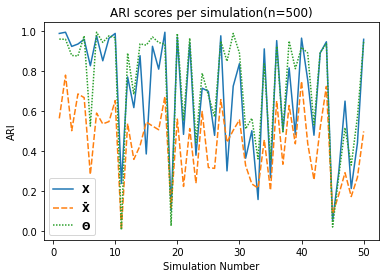

In [46]:
ARI = {"method1": [r"$\mathbf{X}$"]*len(ari_com), "method2": [r"$\mathbf{\bar X}$"]*len(ari_com_norm), "method3":[r"$\mathbf{\Theta}$"]*len(ari_com_theta), r"$\mathbf{X}$": ari_com, r"$\mathbf{\bar X}$": ari_com_norm, r"$\mathbf{\Theta}$": ari_com_theta, "Simulation Number": range(1,len(ari_com)+1)}
ARI = pd.DataFrame(data=ARI)

ARI = ARI.pivot(index="Simulation Number", columns = ["method1", "method2", "method3"], values=[r"$\mathbf{X}$", r"$\mathbf{\bar X}$",r"$\mathbf{\Theta}$"])

sns.lineplot(data=ARI).set_title('ARI scores per simulation(n=500)')
plt.ylabel("ARI")

Let's plot the number of communities estimated by GMM with best BIC/AIC scores

In [ ]:
N_COM = {"method1": [r"$\mathbf{X}$"]*len(n_com), "method2": [r"$\mathbf{\bar X}$"]*len(n_com_norm), "method3":[r"$\mathbf{\Theta}$"]*len(n_com_theta), r"$\mathbf{X}$": n_com, r"$\mathbf{\bar X}$": n_com_norm, r"$\mathbf{\Theta}$": n_com_theta, "Simulation Number": range(1,len(n_com)+1)}
N_COM = pd.DataFrame(data=N_COM)

N_COM = N_COM.pivot(index="Simulation Number", columns = ["method1", "method2", "method3"], values=[r"$\mathbf{X}$", r"$\mathbf{\bar X}$",r"$\mathbf{\Theta}$"])

sns.lineplot(data=N_COM).set_title('Estimated K per simulation')
plt.ylabel("K")

# Average ARI per method

Let's first check the average ARI obtained by applying the GMM using the three different methods

In [48]:
print(np.mean(ari_com))
print(np.std(ari_com))

0.6843354311447737
0.2850285039219778


In [49]:
print(np.mean(ari_com_norm))
print(np.std(ari_com_norm))

0.4417084436293726
0.18744015351248372


In [50]:
print(np.mean(ari_com_theta))
print(np.std(ari_com_theta))

0.7334426761561131
0.27734618000399075


# ARI comparison for $n=1000$ number of nodes

We now repeat previous experiment, this time generating $N=25$ graphs with $n=1000$ nodes and same parameters.

$N = 25,K=3\\
| G_i | = 500\\
G_i \sim DCSBM(B_i, \rho_{ij}) \text{for }i= 1,2,...,N \\
B_i \sim Uniform(0, 1)^{K×K}\\
\rho_{ij} \sim Beta(2, 1)$

In [40]:
## Arguments
n = 1000
M_sim = 25
K = 3

## Set seed to repeat the simulation
np.random.seed(14441)
q = np.array([int(x) for x in np.linspace(0,n,num=K,endpoint=False)])
z = np.zeros(n,dtype=int)
for k in range(K):
    z[q[k]:] = k

n_com_1000 = []
n_com_norm_1000 = []
n_com_theta_1000 = []

ari_com_1000 = []
ari_com_norm_1000 = []
ari_com_theta_1000 = []

## Repeat M_sim times
for s in range(M_sim):
    print(s)
    B = np.tril(np.random.uniform(size=(K,K)))
    B += np.tril(B,k=-1).T

    rho = np.random.beta(a=2,b=1,size=n)
    ## Construct the adjacency matrix
    A = np.zeros((n,n))
    for i in range(n-1):
        for j in range(i+1,n):
            edge = np.random.binomial(n=1,p=rho[i]*rho[j]*B[z[i],z[j]],size=1)
            A[i,j] = edge
            A[j,i] = edge

    ## Obtain the embeddings
    ase = AdjacencySpectralEmbed(n_components=K, check_lcc=False)
    X = ase.fit_transform(A)
    
    #removes latent positions made up only by zeros
    idx_zerorows = np.where(~X.any(axis=1))
    X = np.delete(X, idx_zerorows, 0) #removes latent positions made up only by zeros
    zz = np.delete(z, idx_zerorows, 0) 

    #M = AutoGMMCluster(min_components=2, max_components=7, affinity= 'euclidean', linkage='ward', covariance_type='full')
    M = AutoGMMCluster(min_components=2, max_components=7)
    for t in [None, 'normalised', 'theta']:
      if t == 'normalised':
          M.fit(normalize(X), y=zz)
          n_com_norm_1000.append(M.n_components_)
          ari_com_norm_1000.append(M.ari_)
      elif t == 'theta':
          M.fit(theta_transform(X), y=zz)
          n_com_theta_1000.append(M.n_components_)
          ari_com_theta_1000.append(M.ari_)
      else: 
          M.fit(X, y=zz)
          n_com_1000.append(M.n_components_)
          ari_com_1000.append(M.ari_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


# Plot ARI and estimated number of communities

Let's plot the ARI obtained at each iteration.

Text(0, 0.5, 'ARI')

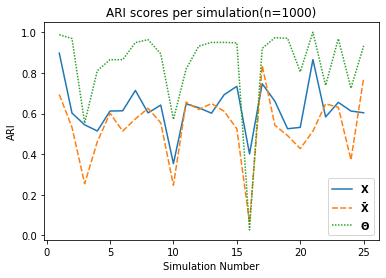

In [47]:
ARI = {"method1": [r"$\mathbf{X}$"]*len(ari_com_1000), "method2": [r"$\mathbf{\bar X}$"]*len(ari_com_norm_1000), "method3":[r"$\mathbf{\Theta}$"]*len(ari_com_theta_1000), r"$\mathbf{X}$": ari_com_1000, r"$\mathbf{\bar X}$": ari_com_norm_1000, r"$\mathbf{\Theta}$": ari_com_theta_1000, "Simulation Number": range(1,len(ari_com_1000)+1)}
ARI = pd.DataFrame(data=ARI)

ARI = ARI.pivot(index="Simulation Number", columns = ["method1", "method2", "method3"], values=[r"$\mathbf{X}$", r"$\mathbf{\bar X}$",r"$\mathbf{\Theta}$"])

sns.lineplot(data=ARI).set_title('ARI scores per simulation(n=1000)')
plt.ylabel("ARI")

Let's plot the number of communities estimated by GMM with best BIC/AIC scores

Text(0, 0.5, 'K')

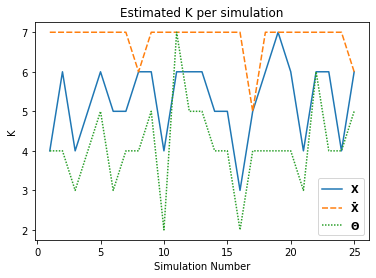

In [42]:
N_COM = {"method1": [r"$\mathbf{X}$"]*len(n_com_1000), "method2": [r"$\mathbf{\bar X}$"]*len(n_com_norm_1000), "method3":[r"$\mathbf{\Theta}$"]*len(n_com_theta_1000), r"$\mathbf{X}$": n_com_1000, r"$\mathbf{\bar X}$": n_com_norm_1000, r"$\mathbf{\Theta}$": n_com_theta_1000, "Simulation Number": range(1,len(n_com_1000)+1)}
N_COM = pd.DataFrame(data=N_COM)

N_COM = N_COM.pivot(index="Simulation Number", columns = ["method1", "method2", "method3"], values=[r"$\mathbf{X}$", r"$\mathbf{\bar X}$",r"$\mathbf{\Theta}$"])

sns.lineplot(data=N_COM).set_title('Estimated K per simulation')
plt.ylabel("K")

# Average ARI per method

In [51]:
print(np.mean(ari_com_1000))
print(np.std(ari_com_1000))

0.6232611987890045
0.11654616976440241


In [52]:
print(np.mean(ari_com_norm_1000))
print(np.std(ari_com_norm_1000))

0.5365632274035438
0.16511948775446278


In [53]:
print(np.mean(ari_com_theta_1000))
print(np.std(ari_com_theta_1000))

0.843468277386185
0.20472690040030653


In [60]:
!jupyter nbconvert --to html /content/Table1_spherical.ipynb

[NbConvertApp] WARNING | pattern u'/content/Table1_spherical.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--inp